# import

In [1]:
import os
import time
import math
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, backend, constraints, initializers
from tensorflow.compat.v1.logging import set_verbosity, ERROR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KernelDensity
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import kstest, ks_2samp, chi2_contingency, wasserstein_distance, norm
from scipy.interpolate import interp1d
from sdv.metadata import MultiTableMetadata
from sdv.evaluation.single_table import evaluate_quality as st_evaluate_quality
from sdv.evaluation.single_table import run_diagnostic as st_run_diagnostic
from sdv.evaluation.multi_table import evaluate_quality as mt_evaluate_quality
from sdv.evaluation.multi_table import run_diagnostic as mt_run_diagnostic

In [2]:
set_verbosity(ERROR)

# load data

In [3]:
def load_data_collection(dir_path):
    gtfs_files = [f for f in os.listdir(dir_path) if f.endswith('.csv') or f.endswith('.txt')]
    data_collection = {}
    for f in gtfs_files:
        f_path = os.path.join(dir_path, f)
        data = pd.read_csv(f_path)
        if data.shape[0] > 1:
            data_collection[f.split(".")[0]] = data
    return data_collection

In [4]:
real_data_collection = load_data_collection("gtfs")

In [5]:
del real_data_collection['shapes']

## Create Metadata

In [6]:
def auto_detect_relation(data_collection):
    metadata = {}
    for df_name, df in data_collection.items():
        parent = {}
        child = {}
        primary_key = None
        foreign_key = []
        for col in df.columns:
            if 'id' in col:
                if df[col].nunique() == len(df):
                    primary_key = col
                else:
                    foreign_key.append(col)
        for foreign_df_name, foreign_df in data_collection.items():
            if foreign_df_name != df_name:
                for fr_col in foreign_df.columns:
                    if 'id' in fr_col:
                        for fr_k in foreign_key:
                            if fr_col == fr_k and foreign_df[fr_col].nunique() == len(foreign_df):
                                parent[foreign_df_name] = fr_k
                        if primary_key != None:
                            if fr_col == primary_key and foreign_df[fr_col].nunique() != len(foreign_df):
                                child[foreign_df_name] = fr_col
        metadata[df_name] = {'primary_key':primary_key,
                             'parent':parent,
                             'child':child,
                             'is_sequential':False,
                            'additional_key':None}
    return metadata

In [7]:
metadata = auto_detect_relation(real_data_collection)
metadata['calendar_dates']['is_sequential'] = True
metadata['stop_times']['is_sequential'] = True
metadata['calendar_dates']['additional_key'] = ['date']
metadata['stop_times']['additional_key'] = ['stop_sequence']
metadata['calendar_dates']['sort_order'] = ['service_id','date']
metadata['stop_times']['sort_order'] = ['trip_id','stop_sequence']

# preprocess

## Create Factorization Dictionary:

In [8]:
def create_ordinal_encoding_dict(data_collection, metadata):
    factor_dict = {}
    for df_name, df in data_collection.items():
        local_id_dict = {}
        primary_key = metadata[df_name]['primary_key']
        if primary_key != None:
            local_id_dict = {k:v for v,k in enumerate(df[primary_key].unique())}
            factor_dict[primary_key] = local_id_dict
    return factor_dict

In [9]:
ordinal_encoding_dict = create_ordinal_encoding_dict(real_data_collection, metadata)

## Format Individual Table:

In [10]:
def individual_preprocess_dict():
    preprocess_dict = {}
    preprocess_dict['transformation'] = {}
    preprocess_dict['transformation']['drop'] = []
    preprocess_dict['transformation']['factorize'] = []
    preprocess_dict['transformation']['to_strip'] = []
    preprocess_dict['transformation']['to_elapsed_time'] = []
    preprocess_dict['transformation']['to_elapsed_days'] = []
    preprocess_dict['nans_conversion'] = {}
    preprocess_dict['nans_conversion']['impute'] = []
    preprocess_dict['nans_conversion']['replace_with_neg_one'] = []
    preprocess_dict['nans_conversion']['replace_with_zeros'] = []
    return preprocess_dict

In [11]:
def format_individual_data(data, preprocess_dict, ordinal_encoding_dict, timestamp = pd.Timestamp('1900-01-01')):
    # reverse_transform_dict = {}
    for stage in preprocess_dict.keys():
        if stage == 'transformation':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'drop':
                        data = data.drop(col_list, axis=1)
                    if method == 'factorize':
                        for col in col_list:
                            if col in ordinal_encoding_dict.keys():
                                data[col] = data[col].map(ordinal_encoding_dict[col])
                            else:
                                data[col] = pd.factorize(data[col], sort=True)[0]
                    if method == 'to_strip':
                        for col in col_list:
                            # convert some column to numbers
                            # e.g. `123-45-6` -> `123456`
                            data[col] = data[col].str.replace(r'\D', '').astype(int)
                    if method == "to_elapsed_time":
                        for col in col_list:
                            cur_col = pd.to_timedelta(data[col])
                            cur_col = cur_col % pd.Timedelta(days=1)
                            data[col] = cur_col.dt.total_seconds()
                    if method == "to_elapsed_days":
                        for col in col_list:
                            cur_col = pd.to_datetime(data[col], format='%Y%m%d') - timestamp
                            data[col] = cur_col.dt.days
        if stage == 'nans_conversion':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'impute':
                        imputer = SimpleImputer(strategy='mean')
                        data[col_list] = imputer.fit_transform(data[col_list])
                    if method == 'replace_with_neg_one':
                        data[col_list] = data[col_list].fillna(-1)
                    if method == 'replace_with_zeros':
                        data[col_list] = data[col_list].fillna(0)
    return data

## preprocess individual data

In [12]:
sdv_metadata = MultiTableMetadata()

In [13]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['agency_name','agency_fare_url','agency_email']
preprocess_dict['transformation']['factorize'] = ['agency_id','agency_url','agency_timezone','agency_lang','agency_phone']
real_data_collection['agency'] = format_individual_data(real_data_collection['agency'], preprocess_dict, ordinal_encoding_dict)

### calendar

In [14]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
real_data_collection['calendar'] = format_individual_data(real_data_collection['calendar'], preprocess_dict, ordinal_encoding_dict)

### calendar_dates

In [15]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['date']
real_data_collection['calendar_dates'] = format_individual_data(real_data_collection['calendar_dates'], preprocess_dict, ordinal_encoding_dict)

In [16]:
sdv_metadata.detect_table_from_dataframe(table_name='calendar_dates',data=real_data_collection['calendar_dates'])
sdv_metadata.update_column(table_name='calendar_dates',column_name='service_id',sdtype='id')
sdv_metadata.update_column(table_name='calendar_dates',column_name='date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='calendar_dates',column_name='exception_type',sdtype='categorical')

### routes

In [17]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['route_short_name','route_long_name','route_desc','route_url','route_sort_order']
preprocess_dict['transformation']['factorize'] = ['route_id',
                                                  'agency_id',
                                                 'route_color',
                                                 'route_text_color',
                                                 'contract_id']
preprocess_dict['nans_conversion']['impute'] = ['route_color','route_text_color']
real_data_collection['routes'] = format_individual_data(real_data_collection['routes'], preprocess_dict, ordinal_encoding_dict)

In [18]:
real_data_collection['routes']['route_color'] = real_data_collection['routes']['route_color'].astype(int)
real_data_collection['routes']['route_text_color'] = real_data_collection['routes']['route_text_color'].astype(int)

### stops

In [19]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['stop_id','parent_station','platform_code']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
preprocess_dict['transformation']['drop'] = ['stop_name','stop_code','stop_desc','zone_id','stop_url','stop_timezone']
preprocess_dict['nans_conversion']['impute'] = ['parent_station','platform_code']
real_data_collection['stops'] = format_individual_data(real_data_collection['stops'], preprocess_dict, ordinal_encoding_dict)

In [20]:
real_data_collection['stops']['parent_station'] = real_data_collection['stops']['parent_station'].astype(int)
real_data_collection['stops']['platform_code'] = real_data_collection['stops']['platform_code'].astype(int)

### stop_times

In [21]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['trip_id','stop_id','stop_headsign']
preprocess_dict['transformation']['to_elapsed_time'] = ['arrival_time','departure_time']
real_data_collection['stop_times'] = format_individual_data(real_data_collection['stop_times'], preprocess_dict, ordinal_encoding_dict)

In [22]:
real_data_collection['stop_times']['arrival_time'] = real_data_collection['stop_times']['arrival_time'].astype(int)
real_data_collection['stop_times']['departure_time'] = real_data_collection['stop_times']['departure_time'].astype(int)

### trips

In [23]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['route_id','service_id','trip_id','trip_headsign','shape_id']
preprocess_dict['transformation']['drop'] = ['trip_short_name','block_id']
real_data_collection['trips'] = format_individual_data(real_data_collection['trips'], preprocess_dict, ordinal_encoding_dict)

## Visualize with SDV (Optional)

In [24]:
sdv_metadata.detect_table_from_dataframe(table_name='agency', data=real_data_collection['agency'])
sdv_metadata.update_column(table_name='agency',column_name='agency_id',sdtype='id')
sdv_metadata.update_column(table_name='agency',column_name='agency_url',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_timezone',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_lang',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_phone',sdtype='categorical')
sdv_metadata.set_primary_key(table_name='agency',column_name='agency_id')

In [25]:
sdv_metadata.detect_table_from_dataframe(table_name='calendar',data=real_data_collection['calendar'])
sdv_metadata.update_column(table_name='calendar',column_name='service_id',sdtype='id')
sdv_metadata.update_column(table_name='calendar',column_name='monday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='tuesday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='wednesday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='thursday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='friday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='saturday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='sunday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='start_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='calendar',column_name='end_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.set_primary_key(table_name='calendar',column_name='service_id')

In [26]:
sdv_metadata.detect_table_from_dataframe(table_name='routes',data=real_data_collection['routes'])
sdv_metadata.update_column(table_name='routes',column_name='route_id',sdtype='id')
sdv_metadata.update_column(table_name='routes',column_name='agency_id',sdtype='id')
sdv_metadata.update_column(table_name='routes',column_name='route_type',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_color',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_text_color',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='contract_id',sdtype='id')
sdv_metadata.set_primary_key(table_name='routes',column_name='route_id')

In [27]:
sdv_metadata.detect_table_from_dataframe(table_name='stops',data=real_data_collection['stops'])
sdv_metadata.update_column(table_name='stops',column_name='stop_id',sdtype='id')
sdv_metadata.update_column(table_name='stops',column_name='stop_lat',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stops',column_name='stop_lon',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stops',column_name='location_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='parent_station',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='platform_code',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='wheelchair_boarding',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='start_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stops',column_name='end_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.set_primary_key(table_name='stops',column_name='stop_id')

In [28]:
sdv_metadata.detect_table_from_dataframe(table_name='stop_times',data=real_data_collection['stop_times'])
sdv_metadata.update_column(table_name='stop_times',column_name='trip_id',sdtype='id')
sdv_metadata.update_column(table_name='stop_times',column_name='arrival_time',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stop_times',column_name='departure_time',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_id',sdtype='id')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_sequence',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_headsign',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='pickup_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='drop_off_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='shape_dist_traveled',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stop_times',column_name='timepoint',sdtype='categorical')

In [29]:
sdv_metadata.detect_table_from_dataframe(table_name='trips',data=real_data_collection['trips'])
sdv_metadata.update_column(table_name='trips',column_name='route_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='service_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='trip_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='trip_headsign',sdtype='categorical')
sdv_metadata.update_column(table_name='trips',column_name='direction_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='shape_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='wheelchair_accessible',sdtype='categorical')
sdv_metadata.update_column(table_name='trips',column_name='bikes_allowed',sdtype='categorical')
sdv_metadata.set_primary_key(table_name='trips',column_name='trip_id')

In [30]:
sdv_metadata.add_relationship(
    parent_table_name='agency',
    child_table_name='routes',
    parent_primary_key='agency_id',
    child_foreign_key='agency_id'
)

sdv_metadata.add_relationship(
    parent_table_name='calendar',
    child_table_name='calendar_dates',
    parent_primary_key='service_id',
    child_foreign_key='service_id'
)

sdv_metadata.add_relationship(
    parent_table_name='calendar',
    child_table_name='trips',
    parent_primary_key='service_id',
    child_foreign_key='service_id'
)

sdv_metadata.add_relationship(
    parent_table_name='routes',
    child_table_name='trips',
    parent_primary_key='route_id',
    child_foreign_key='route_id'
)

sdv_metadata.add_relationship(
    parent_table_name='stops',
    child_table_name='stop_times',
    parent_primary_key='stop_id',
    child_foreign_key='stop_id'
)

sdv_metadata.add_relationship(
    parent_table_name='trips',
    child_table_name='stop_times',
    parent_primary_key='trip_id',
    child_foreign_key='trip_id'
)

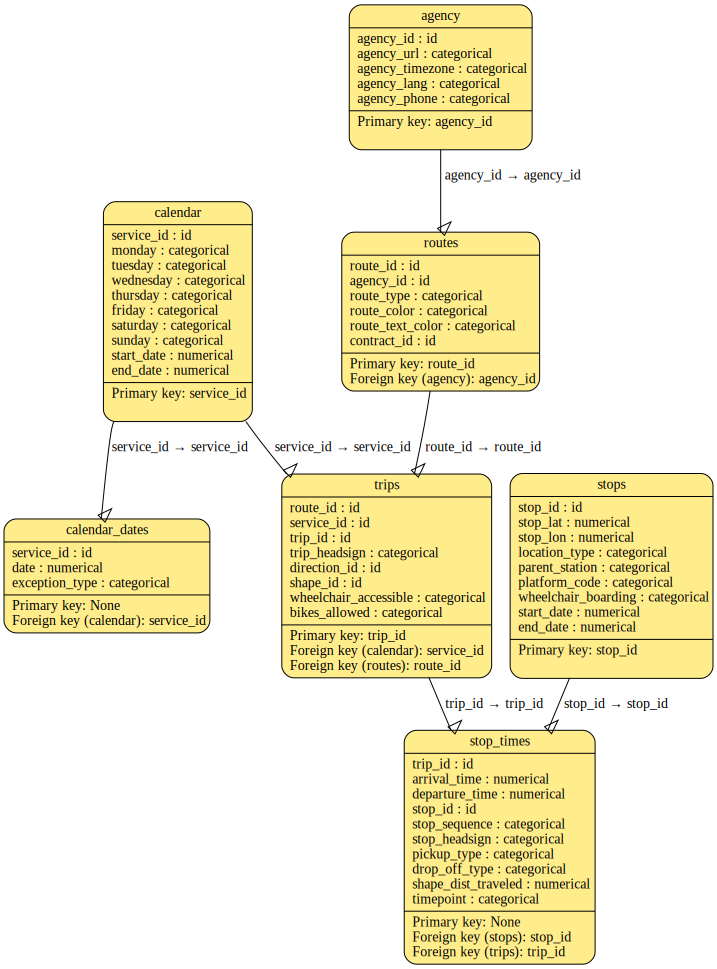

In [31]:
sdv_metadata.visualize()

In [32]:
metadata

{'agency': {'primary_key': 'agency_id',
  'parent': {},
  'child': {'routes': 'agency_id'},
  'is_sequential': False,
  'additional_key': None},
 'calendar': {'primary_key': 'service_id',
  'parent': {},
  'child': {'calendar_dates': 'service_id', 'trips': 'service_id'},
  'is_sequential': False,
  'additional_key': None},
 'calendar_dates': {'primary_key': None,
  'parent': {'calendar': 'service_id'},
  'child': {},
  'is_sequential': True,
  'additional_key': ['date'],
  'sort_order': ['service_id', 'date']},
 'routes': {'primary_key': 'route_id',
  'parent': {'agency': 'agency_id'},
  'child': {'trips': 'route_id'},
  'is_sequential': False,
  'additional_key': None},
 'stops': {'primary_key': 'stop_id',
  'parent': {},
  'child': {'stop_times': 'stop_id'},
  'is_sequential': False,
  'additional_key': None},
 'stop_times': {'primary_key': None,
  'parent': {'stops': 'stop_id', 'trips': 'trip_id'},
  'child': {},
  'is_sequential': True,
  'additional_key': ['stop_sequence'],
  'sor

## Obtain Foreign Key Distribution

In [33]:
def unique_elements(data):
    unique_counts = data.nunique()
    unique_dict = unique_counts.to_dict()
    return unique_dict

In [34]:
def get_distribution(data, n_components=5):
    bgmm = BayesianGaussianMixture(n_components=n_components)
    bgmm.fit(data)
    unique_elements_dict = unique_elements(data)
    return bgmm, unique_elements_dict

In [35]:
def add_key_distribution(data_collection, metadata):
    for df_name, content in metadata.items():
        foreign_key = None
        additional_key = None
        if metadata[df_name]['parent'] != {}:
            foreign_key = list(metadata[df_name]['parent'].values())
        if metadata[df_name]['is_sequential'] == True:
            additional_key = list(metadata[df_name]['additional_key'])
        if foreign_key == None:
            if additional_key != None:
                label_columns =  additional_key
        else:
            if additional_key != None:
                label_columns =  foreign_key + additional_key
            else:
                label_columns =  foreign_key
        if foreign_key != None or additional_key != None:
            distribution, unique_elements = get_distribution(data_collection[df_name][label_columns])
            metadata[df_name]['key_distribution'] = {
                'distribution':distribution,
                'unique_elements':unique_elements
            }

In [36]:
%time add_key_distribution(real_data_collection, metadata)

C:\programs\conda\envs\tfgpu\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\programs\conda\envs\tfgpu\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


CPU times: total: 5min 39s
Wall time: 46.3 s


C:\programs\conda\envs\tfgpu\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


## Scaling

In [37]:
def scale_individual_df(df):
    # scaler = MinMaxScaler((0,1))
    scaler = StandardScaler()
    scaler = scaler.fit(df)
    scaled_df = pd.DataFrame(scaler.transform(df), columns = df.columns)
    return scaled_df, scaler

In [38]:
def extract_key_and_scaled_features(df, label_columns):
    labels = df[label_columns]
    table = df.drop(columns=label_columns)
    table_column_names = table.columns
    scaled_table, table_scaler = scale_individual_df(table)
    scaled_labels, labels_scaler = scale_individual_df(labels)
    return scaled_table, scaled_labels, table_scaler, labels_scaler, table_column_names

In [39]:
def batch_scaling(data_collection, metadata):
    processed_data_collection = {}
    backtransformation_dict = {}
    for df_name, df in data_collection.items():
        primary_key = []
        foreign_key = []
        if metadata[df_name]['primary_key'] != None:
            primary_key = [metadata[df_name]['primary_key']]
        if metadata[df_name]['parent'] != {}:
            foreign_key = list(metadata[df_name]['parent'].values())
        if metadata[df_name]['is_sequential'] == True:
            additional_key = list(metadata[df_name]['additional_key'])
            label_columns = primary_key + foreign_key + additional_key
        else:
            label_columns = primary_key + foreign_key
        table, labels, table_scaler, labels_scaler, table_columns = extract_key_and_scaled_features(df, label_columns)
        processed_data_collection[df_name] = {'table':table,
                                              'labels':labels}
        backtransformation_dict[df_name] = {'table_scaler':table_scaler,
                                            'labels_scaler':labels_scaler,
                                       'table_col_names':table_columns,
                                       'labels_col_names':label_columns,
                                       'col_names':df.columns}
    return processed_data_collection, backtransformation_dict

In [40]:
processed_data_collection, backtransformation_dict = batch_scaling(real_data_collection, metadata)

# Main GAN Algorithm

## Additional Custom Function (Wasserstein Loss) (\*Scrapped\*)

In [41]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true*y_pred)

In [42]:
class ClipConstraint(constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
        
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
    
    def get_config(self):
        return {'clip_value': self.clip_value}

## Define Plotting Function For G/D Loss

In [43]:
import matplotlib.pyplot as plt

def plot_history(logs):
    n = len(logs)
    n_rows = (n + 2) // 3

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, (model_name, generator_log, critic_log) in enumerate(logs):
        axes[i].plot(generator_log, label='gen')
        axes[i].plot(critic_log, label='d')
        axes[i].legend()
        axes[i].set_title(model_name)

    for i in range(n, n_rows * 3):
        axes[i].remove()

    plt.tight_layout()
    plt.show()
    plt.close()

## (!) Define Main Generator, critic

In [44]:
def build_generator(table_dim, labels_dim, latent_dim=50):
    noise_input = layers.Input(shape=(latent_dim,))
    labels_input = layers.Input(shape=(labels_dim,))
    merge_input = layers.Concatenate()([noise_input, labels_input])
    reshape_layer = layers.Reshape((1, -1))(merge_input)
    bn_layer1 = layers.BatchNormalization()(reshape_layer)
    hidden_layer1 = layers.Conv1DTranspose(64,kernel_size=9,activation='LeakyReLU',kernel_initializer='random_normal',padding='same')(bn_layer1)
    bn_layer2 = layers.BatchNormalization()(hidden_layer1)
    hidden_layer2 = layers.Conv1DTranspose(128,kernel_size=9,activation='LeakyReLU',kernel_initializer='random_normal',padding='same')(bn_layer2)
    bn_layer3 = layers.BatchNormalization()(hidden_layer2)
    hidden_layer3 = layers.Conv1DTranspose(256,kernel_size=9,activation='LeakyReLU',kernel_initializer='random_normal',padding='same')(bn_layer3)
    bn_layer4 = layers.BatchNormalization()(hidden_layer3)
    hidden_layer4 = layers.Conv1DTranspose(512,kernel_size=9,activation='LeakyReLU',kernel_initializer='random_normal',padding='same')(bn_layer4)
    bn_layer5 = layers.BatchNormalization()(hidden_layer4)
    flatten_layer = layers.Flatten()(bn_layer5)
    output_layer = layers.Dense(table_dim, activation='tanh',kernel_initializer='random_normal')(flatten_layer)
    generator = models.Model([noise_input, labels_input], output_layer)
    return generator

In [45]:
def build_critic(table_dim, labels_dim, weight_threshold=0.01, optimization_rate=0.00005):
    opt = optimizers.RMSprop(optimization_rate)
    clip = ClipConstraint(weight_threshold)
    table_input = layers.Input(shape=(table_dim,))
    labels_input = layers.Input(shape=(labels_dim,))
    merge_input = layers.Concatenate()([table_input, labels_input])
    reshape_layer = layers.Reshape((1, -1))(merge_input)
    bn_layer1 = layers.BatchNormalization()(reshape_layer)
    hidden_layer1 = layers.Conv1D(512,kernel_size=9,activation='LeakyReLU',kernel_initializer='random_normal',padding='same',kernel_constraint=clip)(bn_layer1)
    bn_layer2 = layers.BatchNormalization()(hidden_layer1)
    hidden_layer2 = layers.Conv1D(256,kernel_size=9,activation='LeakyReLU',kernel_initializer='random_normal',padding='same',kernel_constraint=clip)(bn_layer2)
    bn_layer3 = layers.BatchNormalization()(hidden_layer2)
    hidden_layer3 = layers.Conv1D(128,kernel_size=9,activation='LeakyReLU',kernel_initializer='random_normal',padding='same',kernel_constraint=clip)(bn_layer3)
    bn_layer4 = layers.BatchNormalization()(hidden_layer3)
    hidden_layer4 = layers.Conv1D(64,kernel_size=9,activation='LeakyReLU',kernel_initializer='random_normal',padding='same',kernel_constraint=clip)(bn_layer4)
    bn_layer5 = layers.BatchNormalization()(hidden_layer4)
    flatten_layer = layers.Flatten()(bn_layer5)
    output_layer = layers.Dense(1, activation='linear',kernel_initializer='random_normal')(bn_layer4)
    critic = models.Model([table_input, labels_input], output_layer)
    critic.compile(loss=wasserstein_loss, optimizer=opt)
    return critic

## Build GAN

In [46]:
def build_gan(generator, critic, optimization_rate=0.00005):
    critic.trainable = False
    opt = optimizers.RMSprop(optimization_rate)
    noise_input = layers.Input(shape=(generator.input_shape[0][1],))
    labels_input = layers.Input(shape=(generator.input_shape[1][1],))
    generator_output = generator([noise_input, labels_input])
    critic_output = critic([generator_output, labels_input])
    gan = models.Model(inputs=[noise_input, labels_input], outputs=critic_output)
    gan.compile(optimizer=opt, loss=wasserstein_loss)
    return gan

## Define Training Strategy

In [47]:
def train_individual_gan(name, real_table, real_labels, n_critic=5, epochs=50, batch_size=400, latent_dim=50, seed=123, return_logs=True):
    rand_seed = seed
    half_batch = int(batch_size/2)
    class_counts = real_labels.nunique().tolist()
    generator = build_generator(real_table.shape[1], real_labels.shape[1], latent_dim=latent_dim)
    critic = build_critic(real_table.shape[1], real_labels.shape[1])
    gan = build_gan(generator, critic)
    y_real = -1* np.ones((half_batch, 1))
    y_fake = np.ones((half_batch, 1))
    y_gan = np.ones((batch_size, 1))
    
    if return_logs:
        generator_logs = []
        critic_logs = []
    
    for epoch in range(epochs):
        np.random.seed(rand_seed)
        start_time = time.time()
        c_loss = []
        # train critic:
        for _ in range(n_critic):
            idx = np.random.randint(0, real_table.shape[0], half_batch)
            noise = np.random.normal(0, 1, (half_batch, latent_dim))
            x_real_labels = real_labels.iloc[idx]
            x_real_table = real_table.iloc[idx]
            # x_fake_labels = np.random.normal(0, 1, (half_batch, real_labels.shape[1]))
            # x_fake_labels = np.column_stack([np.random.randint(0, class_counts, size=half_batch) for class_counts in class_counts])
            x_fake_table = generator.predict([noise, x_real_labels])
            c_loss_real = critic.train_on_batch([x_real_table, x_real_labels], y_real)
            c_loss_fake = critic.train_on_batch([x_fake_table, x_real_labels], y_fake)
            c_loss.append(np.mean(c_loss_real+c_loss_fake))
            rand_seed += 1
            
        c_loss = np.mean(c_loss)
        # train generator/GAN
        idx = np.random.randint(0, real_table.shape[0], batch_size)
        x_real_labels = real_labels.iloc[idx]
        x_gan = np.random.normal(0, 1, (batch_size, latent_dim))
        # x_fake_labels = np.random.normal(0, 1, (batch_size, real_labels.shape[1]))
        # x_fake_labels = np.column_stack([np.random.randint(0, class_counts, size=batch_size) for class_counts in class_counts])
        g_loss = gan.train_on_batch([x_gan, x_real_labels], y_gan)
        
        if return_logs:
            generator_logs.append(g_loss)
            critic_logs.append(c_loss)
            
        elapsed_time = time.time() - start_time
        it_per_s = 1 / elapsed_time
        
        if epoch % 10 == 0 or epoch in [0,epochs-1]:
            print(f"[Epoch: {epoch}] [C loss: {np.round(c_loss, 3)}] [G loss: {np.round(g_loss, 3)}] [Speed: {round(it_per_s, 2)} it/s]")
        
        rand_seed += 1
        
    generator.save('models/'+name+'_gen.h5')
    # gan.save('models/'+name+'_gan.h5')
    # critic.save('models/'+name+'_critic.h5')
    
    if return_logs:
        return generator_logs, critic_logs

In [48]:
def train_individual_sequential_gan(name, real_table, real_labels, sort_order, n_critic=5, epochs=50, batch_size=400, latent_dim=50, seed=123, return_logs=True):
    rand_seed = seed
    half_batch = int(batch_size/2)
    class_counts = real_labels.nunique().tolist()
    sort_indexes = [real_labels.columns.get_loc(col) for col in sort_order]
    generator = build_generator(real_table.shape[1], real_labels.shape[1], latent_dim=latent_dim)
    critic = build_critic(real_table.shape[1], real_labels.shape[1])
    gan = build_gan(generator, critic)
    y_real = -1 * np.ones((half_batch, 1))
    y_fake = np.ones((half_batch, 1))
    y_gan = np.ones((batch_size, 1))
    
    if return_logs:
        generator_logs = []
        critic_logs = []
    
    for epoch in range(epochs):
        np.random.seed(rand_seed)
        start_time = time.time()
        c_loss = []
        
        # train critic:
        for _ in range(n_critic):
            half_samp_size = min(half_batch, real_table.shape[0])
            idx = random.randint(0, real_table.shape[0]-half_samp_size)
            noise = np.random.normal(0, 1, (half_samp_size, latent_dim))
            x_real_labels = real_labels.iloc[idx:(idx+half_samp_size)]
            x_real_table = real_table.iloc[idx:(idx + half_samp_size)]
            # x_fake_labels = np.random.normal(0, 1, (half_samp_size, real_labels.shape[1]))
            # x_fake_labels = x_fake_labels[x_fake_labels[:, sort_indexes[0]].argsort()]
            # for col_idx in sort_indexes[1:]:
            #     x_fake_labels = x_fake_labels[x_fake_labels[:, col_idx].argsort(kind='mergesort')]
            x_fake_table = generator.predict([noise, x_real_labels])
            c_loss_real = critic.train_on_batch([x_real_table, x_real_labels], y_real)
            c_loss_fake = critic.train_on_batch([x_fake_table, x_real_labels], y_fake)
            c_loss.append(np.mean(c_loss_real+c_loss_fake))
            rand_seed += 1
        
        c_loss = np.mean(c_loss)
        # train generator/GAN
        samp_size = min(batch_size, real_table.shape[0])
        x_gan = np.random.normal(0, 1, (samp_size, latent_dim))
        idx = random.randint(0, real_table.shape[0]-samp_size)
        x_real_labels = real_labels.iloc[idx:(idx+samp_size)]
        g_loss = gan.train_on_batch([x_gan, x_real_labels], y_gan)
        
        if return_logs:
            generator_logs.append(g_loss)
            critic_logs.append(c_loss)
            
        elapsed_time = time.time() - start_time
        it_per_s = 1 / elapsed_time
        
        if epoch % 10 == 0 or epoch in [0,epochs-1]:
            print(f"[Epoch: {epoch}] [C loss: {np.round(c_loss, 3)}] [G loss: {np.round(g_loss, 3)}] [Speed: {round(it_per_s, 2)} it/s]")
        
        rand_seed += 1
        
    generator.save('models/'+name+'_gen.h5')
    # gan.save('models/'+name+'_gan.h5')
    # critic.save('models/'+name+'_critic.h5')
    
    if return_logs:
        return generator_logs, critic_logs

In [49]:
def collection_training(processed_collection, metadata, training_parameter_dict):
    logs = []
    init_time = time.time()
    for df_name, content in processed_collection.items():
        start_time = time.time()
        print(f'Learning \"{df_name}\" data......')
        latent_dim = 100
        if metadata[df_name]['is_sequential'] == True:
            generator_log, critic_log = train_individual_sequential_gan(df_name,
                                                                        content['table'],
                                                                        content['labels'],
                                                                        metadata[df_name]['sort_order'],
                                                                        epochs=training_parameter_dict[df_name]['epochs'],
                                                                        latent_dim = latent_dim,
                                                                        return_logs=True)
        else:
            generator_log, critic_log = train_individual_gan(df_name,
                                                             content['table'],
                                                             content['labels'],
                                                             epochs=training_parameter_dict[df_name]['epochs'],
                                                             latent_dim = latent_dim,
                                                             return_logs=True)
        in_loop_elapsed_time = time.time() - start_time
        minutes, seconds = divmod(in_loop_elapsed_time, 60)
        print("Time Used: %dm %ds" % (minutes, seconds))
        print('.')
        print('.')
        logs.append([df_name, generator_log, critic_log])
    plot_history(logs)
    total_elapsed_time = time.time() - init_time
    minutes, seconds = divmod(total_elapsed_time, 60)
    print("Total Time Used: %dm %ds" % (minutes, seconds))

## Train GAN

In [50]:
def calculate_epochs(data_collection, batch_size=400):
    parameter_dict = {}
    for df_name, df in data_collection.items():
        epochs = len(df) / batch_size
        if epochs < 5:
            epochs = 5
        elif epochs > 500:
            epochs = 500
        parameter_dict[df_name] = {'epochs':round(epochs)}
    return parameter_dict

In [51]:
training_parameter_dict = calculate_epochs(real_data_collection)

In [52]:
training_parameter_dict

{'agency': {'epochs': 5},
 'calendar': {'epochs': 5},
 'calendar_dates': {'epochs': 5},
 'routes': {'epochs': 5},
 'stops': {'epochs': 17},
 'stop_times': {'epochs': 500},
 'trips': {'epochs': 81}}

In [53]:
# training_parameter_dict = {'agency': {'epochs': 100},
#                            'calendar': {'epochs': 100},
#                            'calendar_dates': {'epochs': 200},
#                            'routes': {'epochs': 100},
#                            'stops': {'epochs': 100},
#                            'stop_times': {'epochs': 200},
#                            'trips': {'epochs': 100}}

Learning "agency" data......
[Epoch: 0] [C loss: 0.001] [G loss: -0.001] [Speed: 0.14 it/s]
[Epoch: 4] [C loss: 0.0] [G loss: -0.008] [Speed: 2.32 it/s]
Time Used: 0m 10s
.
.
Learning "calendar" data......
[Epoch: 0] [C loss: 0.001] [G loss: 0.002] [Speed: 0.24 it/s]
[Epoch: 4] [C loss: 0.0] [G loss: 0.01] [Speed: 1.55 it/s]
Time Used: 0m 7s
.
.
Learning "calendar_dates" data......
[Epoch: 0] [C loss: 0.001] [G loss: -0.001] [Speed: 0.24 it/s]
[Epoch: 4] [C loss: 0.0] [G loss: -0.005] [Speed: 1.62 it/s]
Time Used: 0m 7s
.
.
Learning "routes" data......
[Epoch: 0] [C loss: 0.0] [G loss: 0.001] [Speed: 0.24 it/s]
[Epoch: 4] [C loss: 0.0] [G loss: 0.001] [Speed: 2.2 it/s]
Time Used: 0m 6s
.
.
Learning "stops" data......
[Epoch: 0] [C loss: 0.001] [G loss: -0.005] [Speed: 0.24 it/s]
[Epoch: 10] [C loss: 0.0] [G loss: -0.04] [Speed: 1.58 it/s]
[Epoch: 16] [C loss: 0.0] [G loss: -0.065] [Speed: 1.57 it/s]
Time Used: 0m 13s
.
.
Learning "stop_times" data......
[Epoch: 0] [C loss: 0.001] [G lo

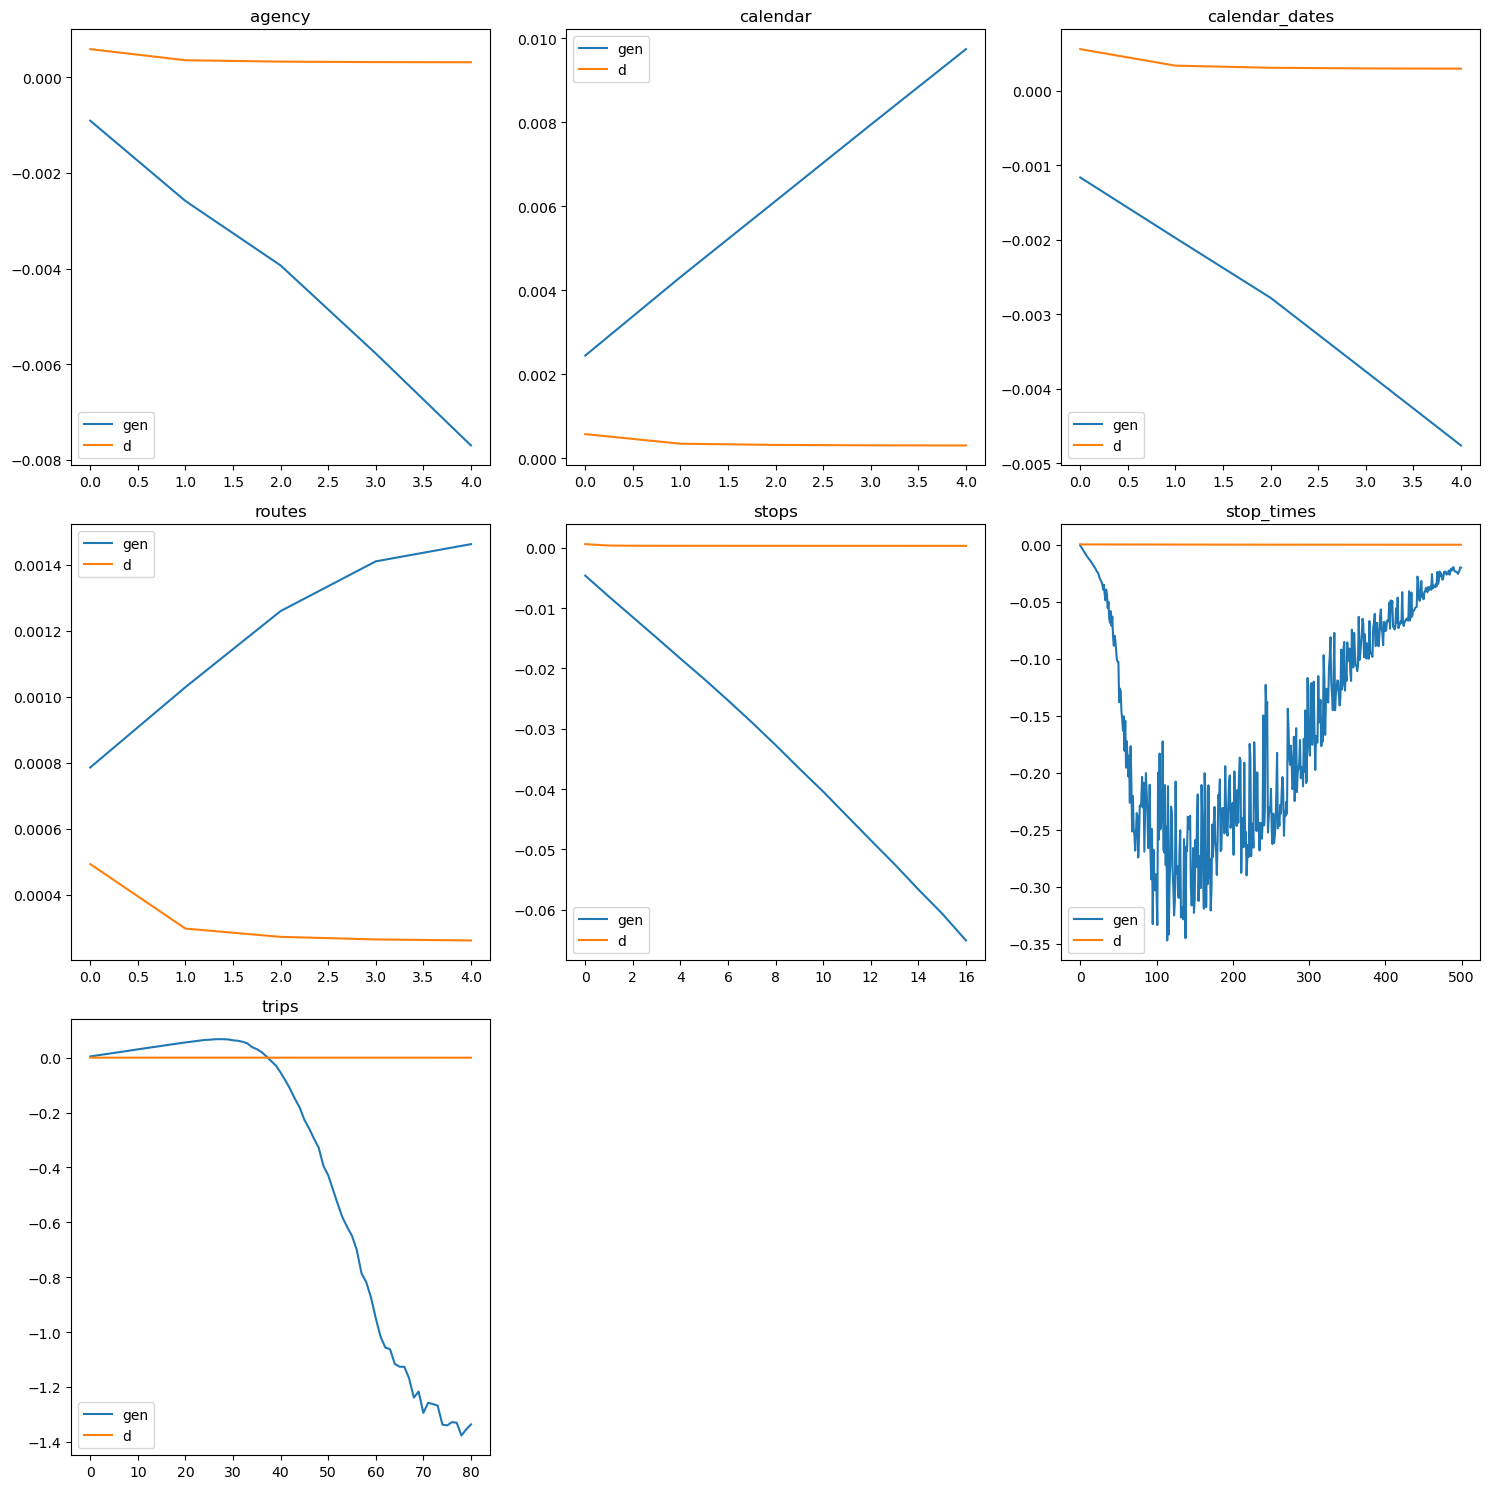

Total Time Used: 7m 4s
CPU times: total: 8min 16s
Wall time: 7min 4s


In [54]:
%%time

collection_training(processed_data_collection, metadata, training_parameter_dict)

# Synthetic Data Generation

In [55]:
def generate_data(bgmm, n_samples):
    means = bgmm.means_
    covariances = bgmm.covariances_
    weights = bgmm.weights_
    new_data = np.zeros((n_samples, bgmm.means_.shape[1]))
    for i in range(n_samples):
        component = np.random.choice(range(len(weights)), p=weights)
        new_data[i, :] = np.random.multivariate_normal(means[component], covariances[component])
    return new_data

In [56]:
def adjust_unique_elements(data, unique_elements):
    for col, n_unique in unique_elements.items():
        data[col] = np.round(data[col]).astype(int)
        min_val, max_val = data[col].min(), data[col].max()
        original_range = np.linspace(min_val, max_val, n_unique)
        new_range = np.arange(n_unique)
        interp_func = interp1d(original_range, new_range, kind='linear', bounds_error=False, fill_value=(0, n_unique - 1))
        data[col] = interp_func(data[col]).astype(int)
    return data

In [57]:
def generate_table(bgmm, n_samples, unique_elements):
    new_data = generate_data(bgmm, n_samples)
    new_data_df = pd.DataFrame(new_data, columns=list(unique_elements.keys()))
    adjusted_data_df = adjust_unique_elements(new_data_df, unique_elements)
    return adjusted_data_df

In [58]:
def generate_synth_data_collection(metadata, generation_dict, backtransformation_dict, latent_dim=100, seed=123):
    np.random.seed(seed)
    synthetic_data_collection = {}
    features_to_ignore_rounding = ['shape_pt_lat',
                      'shape_pt_lon',
                      'stop_lat',
                      'stop_lon',
                     'shape_dist_traveled']
    
    for df_name, content in metadata.items():
        generator = models.load_model('models/'+df_name+'_gen.h5')
        primary_key = content['primary_key']
        child = content['child']
        parent = content['parent']
        n_samples = generation_dict[df_name]['nrows']
        
        fake_primary_key = None
        fake_foreign_keys = None
        if primary_key != None:
            fake_primary_key = np.arange(n_samples).tolist()
            fake_primary_key = pd.DataFrame({primary_key:fake_primary_key})
        
        unique_elements = {}
        if parent != {} or content['is_sequential'] == True:
            distribution = content['key_distribution']['distribution']
            if parent != {}:
                for par,fr_k in parent.items():
                    unique_elements[fr_k] = generation_dict[par]['nrows']
            if content['is_sequential'] == True:
                for alt_key in content['additional_key']:
                    unique_elements[alt_key] = content['key_distribution']['unique_elements'][alt_key]
        if unique_elements != {}:
            fake_foreign_keys = generate_table(distribution, n_samples, unique_elements)
        
        if primary_key != None:
            if parent != {}:
                fake_labels_df = pd.concat([fake_primary_key, fake_foreign_keys], axis=1)
            else:
                fake_labels_df = fake_primary_key
        else:
            fake_labels_df = fake_foreign_keys
                
        fake_labels_df = fake_labels_df.reindex(columns=backtransformation_dict[df_name]['labels_col_names'])
        
        if content['is_sequential'] == True:
            fake_labels_df = fake_labels_df.sort_values(by=content['sort_order'])
            
        scaled_fake_labels_df = pd.DataFrame(backtransformation_dict[df_name]['labels_scaler'].transform(fake_labels_df), columns=fake_labels_df.columns)
        
        latent_dim = 100
        noise = np.random.normal(0, 1, size=(n_samples, latent_dim))
        raw_fake_table = generator.predict([noise, scaled_fake_labels_df])
        scaled_fake_table = backtransformation_dict[df_name]['table_scaler'].inverse_transform(raw_fake_table)
        fake_table_df = pd.DataFrame(scaled_fake_table, columns=backtransformation_dict[df_name]['table_col_names'])
        fake_data = pd.concat([fake_labels_df, fake_table_df], axis=1)
        fake_data = fake_data.reindex(columns=backtransformation_dict[df_name]['col_names'])
        
        columns_to_int = [col for col in fake_data.columns if col not in features_to_ignore_rounding]
        for col in columns_to_int:
            fake_data[col] = fake_data[col].round().astype(int)
                
        synthetic_data_collection[df_name] = fake_data
        
    return synthetic_data_collection

In [59]:
generation_dict = {k:{'nrows':len(v['table'])} for k,v in processed_data_collection.items()}
generation_dict['calendar_dates']['sort_by'] = ['service_id','date']
generation_dict['stop_times']['sort_by'] = ['trip_id','stop_sequence']

In [60]:
generation_dict

{'agency': {'nrows': 15},
 'calendar': {'nrows': 121},
 'calendar_dates': {'nrows': 674, 'sort_by': ['service_id', 'date']},
 'routes': {'nrows': 215},
 'stops': {'nrows': 6714},
 'stop_times': {'nrows': 966790, 'sort_by': ['trip_id', 'stop_sequence']},
 'trips': {'nrows': 32403}}

In [61]:
%%time

synthetic_data_collection = generate_synth_data_collection(metadata, generation_dict, backtransformation_dict)

CPU times: total: 2min 54s
Wall time: 2min 39s


In [62]:
# del processed_data_collection

In [63]:
with open('pkl/real_data.pkl', 'wb') as f:
    pickle.dump(real_data_collection, f)

In [64]:
with open('pkl/synthetic_data_full_epoch.pkl', 'wb') as f:
    pickle.dump(synthetic_data_collection, f)

In [65]:
# with open('pkl/synthetic_data_10epoch.pkl', 'wb') as f:
#     pickle.dump(synthetic_data_collection, f)

In [66]:
with open('pkl/sdv_metadata.pkl', 'wb') as f:
    pickle.dump(sdv_metadata, f)

In [67]:
with open('pkl/metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)